
$$

		\text{In the Name of God}\\
		\
		\Large
		\textbf{Introduction to Machine Learning (25737-2)} \\
		\\
		\text{Project Report (Phase 1)}\\
		\\
		\large
		\text{Spring Semester 1401-02}\\
		\\
		\text{Department of Electrical Engineering}\\
		\\
		\text{Sharif University of Technology}\\
		{Instructor: Dr. S. Amini}\\
		\\
		\text{  }\\
		\text{Alireza Shokrani} \quad 99106255\\
		\\
		\text{Amirhossein Akbari} \quad 99105901\\
$$


### Import requirements (RUN FIRST)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from scipy.stats import multivariate_normal  
import random


## E-step Function ##
In this function, using the obtained closed form, we update q with the optimal possible value.
$$\hat{q_{i}}^{(t + 1)} =  \frac{\pi_{i}\mathcal{N}(y_i; \mu_k,\,\Sigma_k)}{\sum_{k = 1}^{K} \pi_{k}\mathcal{N}(y_i; \mu_k,\,\Sigma_k)}$$
The reason why we have not written the normal probability density calculation in closed-form is that we have used ```multivariate_normal``` object from ```scipy.stats``` library to calculate it. The E-step function can now be used to estimate the mixture model of another random distribution family by replacing the mentioned object with another probability density.


In [24]:
def E_step(data, mu, sigma, pi):
    Q = np.asarray([pi[i] * multivariate_normal.pdf(data, mu[i,:], sigma[i,:,:]) for i in range(n)]).T
    Q = Q / np.reshape(np.sum(Q, axis=1),(len(data), 1))
    return Q


## M-step Function

In this function, using the closed form obtained from the relation:
$$\theta^{(t + 1)} = \argmax_{\theta}\sum_{n}^{} \mathbb{E}_{q_{n}^{(t)}}[log(p_{\mathbf{Y},\mathbf{Z}}(\mathbf{y}_{n},\mathbf{z}_{n};\theta))]$$
which is in the form below for :
$$\displaystyle \mu _{k}^{(t + 1)}:={\frac {\sum _{n=1}^{N}q_{k}^{(n)}y^{(n)}}{\sum _{n=1}^{N}q_{k}^{(n)}}}$$
$${\displaystyle \Sigma _{k}^{(t + 1)}:={\frac {\sum _{n=1}^{N}q_{k}^{(n)}\left(y^{(n)}-\mu _{k}^{(t + 1)}\right)\left(y^{(n)}-\mu _{k}^{(t + 1)}\right)^{T}}{\sum _{n=1}^{N}q_{k}^{(n)}}}}$$
$$\pi_{k}^{(t + 1)} = \frac{\sum_{n = 1}^{N} q_k^{(n)}}{N}$$
we will update ```mu, sigma, pi``` as model parameters.



In [25]:
def M_step(data, sigma, Q, n):
    mu =  np.asarray([np.average(data, weights=Q[:,i], axis=0) for i in range(n)])
    for i in range(n):
        sigma[i, :, :] = (data - mu[i,:]).T @ np.multiply((data - mu[i,:]), np.tile(Q[:,i], (2,1)).T)
        sigma[i, :, :] = sigma[i, :, :] / np.sum(Q[:,i])
    pi = np.mean(Q, axis=0)
    return mu, sigma, pi

## Drawing and Measuring functions

function ```plot_M(mu, sigma, data, n, colors)``` draws the contour lines of distributions based on model parameters.

function ```plot_E(data, Q, n, colors)``` takes ```Q = [qn(Zn)] , n = [1, ... , N]``` as calculated in E-step Using its argmaxes, it categorizes the data and draws it on the screen.

function ```cluster_match_percent(Q)``` compares the matching rate of the clustering performed in the algorithm with the actual clusters of data.

In [26]:
def plot_M(mu, sigma, data, n, colors):

    # this function draws the contour lines of distributions based on model parameters.
    # mu is stacked matrix of [x, y] as means of prob. distributions
    # sigma is stacked matrix of Sigma's of prob. distributions
    # it neads vector of colors to draw each cluster with that color

    rng = np.vstack((np.min(data, axis=0), np.max(data, axis=0)))
    x1 = np.linspace(rng[0,0],rng[1,0],200)  
    x2 = np.linspace(rng[0,1],rng[1,1],200)
    X, Y = np.meshgrid(x1,x2)

    pos = np.empty(X.shape + (2,))               
    pos[:, :, 0] = X; pos[:, :, 1] = Y   

    plt.figure()
    plt.grid()                                                           
    #plt.scatter(data[:,0], data[:,1], s = 3)   # If we want to see the all data together homochromatic under the model
    #print(mu)
    for i in range(n):
        Z = multivariate_normal(mu[i,:], sigma[i,:,:])
        plt.contour(X, Y, Z.pdf(pos), colors=colors[i] ,alpha = 0.5) 
    plt.axis('equal')                                                                  
                                                                            




def plot_E(data, Q, n, colors):

    # this function takes Q = [qn(Zn)] , n = [1, ... , N] as calculated in E-step Using its argmaxes, it categorizes the data and draws it on the screen.

    Z = np.argmax(Q, axis=1)
    plt.scatter(data[:,0], data[:,1],color = np.choose(Z,colors), s = 3)




def cluster_match_percent(Q):

    # It compares the matching value of the classification
    # obtained from the algorithm with the actual classification of
    # the information.

    calc_clusters = np.argmax(Q, axis=1)
    indexes = [np.median(calc_clusters[:200]),np.median(calc_clusters[200:400]),np.median(calc_clusters[400:])]
    real_clusters = np.repeat(indexes,200,axis=0)
    return (1 - np.sum((real_clusters - calc_clusters) != 0) / 600) * 100



## Question 1 
### plotting data

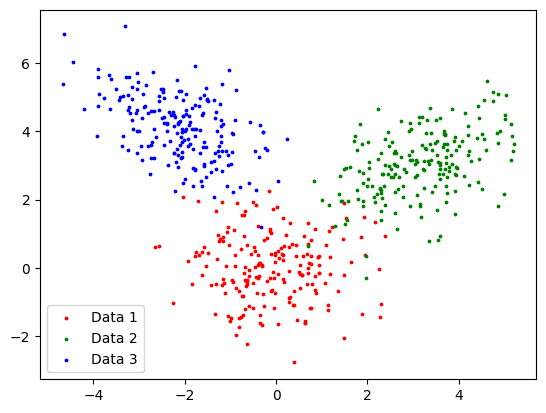

In [27]:
data = np.loadtxt('image1.csv', skiprows=1, delimiter=',')                      #load image to an matrix of size (2, N)
data = data[:, 1:]

#Plot each cluster of data manually
plt.scatter(data[:200,0],data[:200, 1], color='r', label='Data 1', s = 3)
plt.scatter(data[200:400, 0],data[200:400, 1], color='g', label='Data 2', s = 3)
plt.scatter(data[400:, 0], data[400:, 1], color='b', label='Data 3', s = 3)
plt.legend()
plt.show()

## Initialization ##

In [28]:
n = 3                                                   #number of categories
colors = ['r', 'g', 'b']                                #vector of colors for plotting functions                               

#Initialize model values
mu = data[np.random.randint(0, data.shape[0], n), :]    #Matrix of means
sigma = np.tile(np.cov(data.T), (n,1,1))                #Matrix of covariances
pi = np.repeat(1/n, n, axis = 0)                        #Probability matrix of categories


# Execution

## Question 2
### First E-step perform

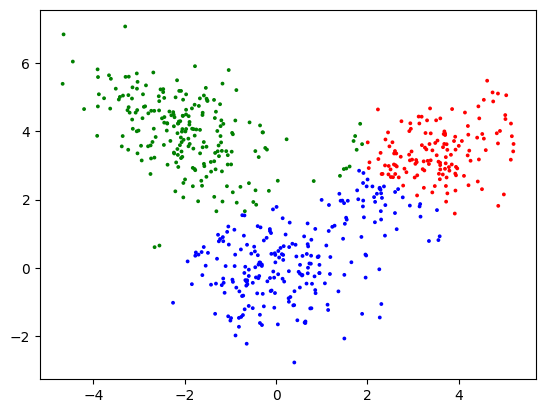

In [29]:
Q = E_step(data, mu, sigma, pi)
plot_E(data, Q, n, colors)

As we can see, due to the initial parameters of the model, which are completely random, the initial clustering is unbalanced.

## Question 3
### First M-step perform

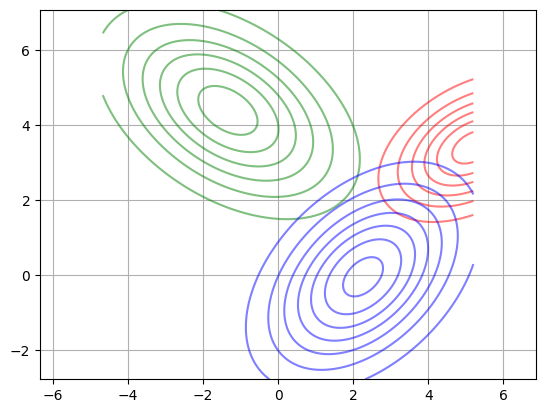

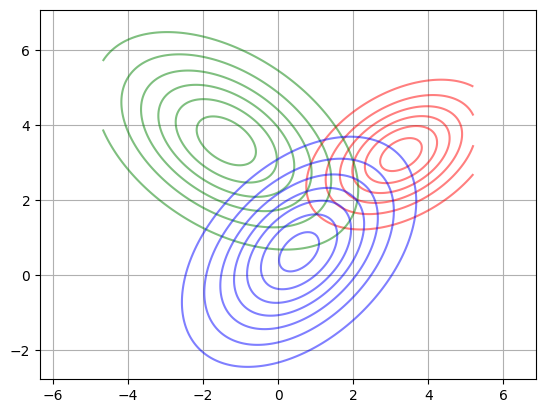

In [30]:
new_mu, new_sigma, new_pi = M_step(data, sigma, Q, n)

plot_M(mu, sigma, data, n, colors)

plot_M(new_mu, new_sigma, data, n, colors)



As we can see, model parameters changed and moved a bit to fit on data.

## Question 4

### Running the algorithm until convergence occurs


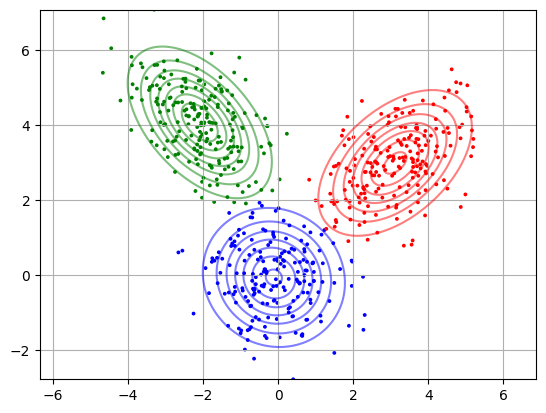

In [31]:
dif = 1000
while dif > 0.01:
    Q = E_step(data, mu, sigma, pi)
    new, sigma, pi = M_step(data, sigma, Q, n)
    dif = np.linalg.norm(new - mu)
    mu = new
plot_M(mu, sigma, data, n, colors)
plot_E(data, Q, n, colors)
plt.show()

As you can see, the algorithm has fitted n number of Gaussian distributions to the data, below we have also calculated the matching rate of the clustering using the ```cluster_match_percent ```function.

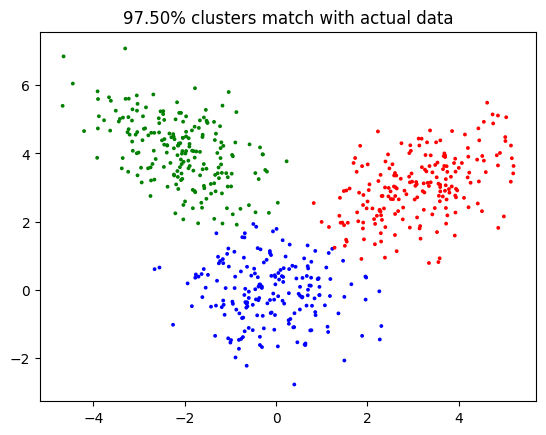

In [36]:
plot_E(data, Q, n, colors)
print()
plt.title("%.2f" % cluster_match_percent(Q) + "% clusters match with actual data")
plt.show()

## Question 5
### EM performance comparison
In ```image1.csv```, we have a series of separate Gaussian distributions that are distinguishable from each other, in this situation, the algorithm performs clustering well in addition to fitting the appropriate mixture model.
But like ```image2.csv```, when the distribution of input information is completely superimposed and mixed, it is no longer possible to distinguish between them, and leads to low clustering match percent.
In this situation, we realize that the complexity of the model is high and the categories number criterion (n) should be reduced.